In [68]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [69]:
from fastai.text import *
import torch

In [70]:
#df = pd.read_csv('./Final_Intent_Dataset_OOS_Plus.csv')
df = pd.read_csv('./Final_Intent_Dataset_OOS_TextGen.csv')
df.head()

,label,text,is_valid
0,account_blocked,why is there a hold on my american saving bank...,True
1,account_blocked,i am nost sure why my account is blocked,True
2,account_blocked,why is there a hold on my capital one checking...,True
3,account_blocked,i think my account is blocked but i do not kno...,True
4,account_blocked,can you tell me why is my bank account frozen,True


In [71]:
df['text'][1]

'i am nost sure why my account is blocked'

In [72]:
path = '/notebooks/storage/'

### Language Model

In [73]:
#data_lm = TextDataBunch.from_csv(path, 'Final_Intent_Dataset_OOS_Plus.csv')
data_lm = TextDataBunch.from_csv(path, 'Final_Intent_Dataset_OOS_TextGen.csv')

In [74]:
data_lm.save('tmp_lm')

In [75]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=32)

In [76]:
data_lm.show_batch()

idx,text
0,n't i get into my account xxbos do you know how i can change my insurance policy xxbos how do i rollover my 401k xxbos i need to report unauthorized activity on my card xxbos submit payment to xxunk energy for my electric bill xxbos when is my cell phone bill due xxbos who is the best architecture xxbos can you tell me how much i owe on my cable
1,"how do i apply for new insurance xxbos tell me my current health plan xxbos what 's my credit score rating xxbos what is my exact credit score xxbos i xxunk "" were the xxunk "" on netflix last xxunk xxbos what is the lowest amount i can pay for my insurance bill xxbos what health coverage do i have xxbos how long before my xxunk cc takes to arrive"
2,xxunk rate xxbos what is the deadline to xxunk at university of xxunk xxbos which insurance plan am i enrolled in xxbos how much do i have in savings xxbos what date is my water bill due xxbos you need to tell me my credit card 's apr xxbos let 's use my credit card points xxbos what was xxunk with my card yesterday xxbos what 's the healthcare plan
3,change the pin on my wells fargo account to be 1234 xxbos will you let me know what my spending limit is xxbos can you tell me when my credit card application will be processed xxbos which insurance plan do i have xxbos how do i report that i lost my card xxbos i was at xxunk trying to buy xxunk and my card got declined xxbos does medical xxunk
4,"me my credit rating xxbos will you notify me when my new card is on the way xxbos please answer the phone and put it on xxunk on the tv xxbos please tell me this month 's transactions on my visa xxbos i can not use my card , it is damaged xxbos is the united states a xxunk xxbos how much am i xxunk to pay in tax xxbos"


In [77]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'my',
 'i']

In [78]:
data_lm.train_ds[0][0]

Text xxbos can i make a change to my credit limit

In [79]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

In [80]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


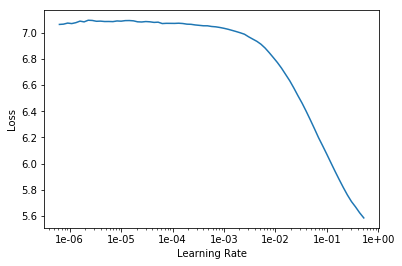

In [81]:
learn.recorder.plot(skip_end=15)

In [82]:
learn.fit_one_cycle(1, 1e-01, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.931718,2.789697,0.394792


In [83]:
#learn.save('fit_head')

In [84]:
#learn.load('fit_head')

In [85]:
learn.unfreeze()

In [86]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,2.862712,2.514009,0.436310


In [87]:
#learn.save('fine_tuned')

In [88]:
#learn.load('fine_tuned')

In [89]:
TEXT = "What is the credit"
N_WORDS = 10
N_SENTENCES = 1

In [90]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

What is the credit limit on my discover card xxbos i would like to


In [91]:
learn.save_encoder('fine_tuned_enc')

### Classifier

In [92]:
# data_clas = (TextList.from_csv(path, 'Final_Intent_Dataset_OOS_Plus.csv', cols='text')
#                 .split_from_df(col=2)
#                 .label_from_df(cols=0)
#                 .databunch())
data_clas = (TextList.from_csv(path, 'Final_Intent_Dataset_OOS_TextGen.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

In [93]:
#data_clas = TextClasDataBunch.from_csv(path, 'Final_Intent_Dataset_OOS_Plus.csv', vocab=data_lm.train_ds.vocab, bs=32)
data_clas = TextClasDataBunch.from_csv(path, 'Final_Intent_Dataset_OOS_TextGen.csv', vocab=data_lm.train_ds.vocab, bs=32)

In [94]:
data_clas.save('tmp_clas')

In [95]:
data_clas.show_batch()

text,target
xxbos xxmaj is there a bill currently in the xxmaj xxunk that would prevent xxmaj xxunk xxmaj xxunk from being xxunk in our xxmaj xxunk,oos
xxbos xxmaj if the person has no say in the xxunk do they have a right to xxunk a request for a request for a bill,oos
xxbos how long will it take me to pay off my card if i pay an extra $ 50 a month over the minimum,oos
xxbos i keep trying to figure out if i have enough money in my chase account to purchase a new set of xxunk,balance
xxbos i recently lost my credit card and need to know how long it takes to get a new one mailed to me,replacement_card_duration


In [96]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [97]:
learn.freeze()

In [98]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


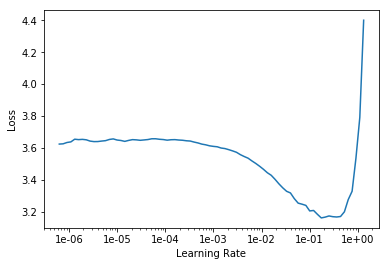

In [99]:
learn.recorder.plot()

In [100]:
learn.fit_one_cycle(10, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,1.388285,0.684649,0.819579
2,1.162192,0.573222,0.819579
3,1.079894,0.737359,0.807443
4,0.966048,0.470276,0.860841
5,0.909396,0.417173,0.880259
6,0.801179,0.387327,0.876214
7,0.746703,0.352040,0.893204
8,0.608191,0.293094,0.913430
9,0.590194,0.290331,0.907767
10,0.567831,0.274533,0.913430


In [101]:
#learn.save('after-first-training')

In [102]:
#learn.load('after-first-training')

In [103]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.623664,0.299333,0.911003


In [104]:
#learn.save('after-second-training')

In [105]:
#learn.load('after-second-training')

In [106]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.387489,0.204205,0.935275


In [107]:
#learn.save('after-third-training')

In [108]:
#learn.load('after-third-training')

In [109]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.353008,0.197783,0.940129
2,0.334404,0.186591,0.941748
3,0.262757,0.163626,0.943366
4,0.212075,0.150976,0.953074
5,0.208490,0.153566,0.949838


In [110]:
learn.predict("why can't i access my chase account")

(Category account_blocked,
 tensor(0),
 tensor([9.9965e-01, 1.5145e-08, 4.0042e-11, 2.2589e-06, 3.4799e-09, 1.6234e-08,
         3.2552e-04, 9.0416e-10, 4.1750e-09, 2.1177e-10, 2.1556e-08, 2.7024e-07,
         4.9671e-08, 1.4458e-09, 1.1381e-05, 8.0500e-09, 5.0782e-08, 2.9572e-08,
         1.2053e-07, 3.1211e-09, 4.5314e-09, 4.3927e-10, 7.3368e-07, 3.2142e-08,
         8.1899e-09, 1.3003e-05, 5.8752e-10, 5.4060e-09, 7.7736e-08, 7.6776e-09,
         2.8694e-09, 8.8664e-09, 4.9486e-09, 1.9876e-08, 9.7140e-08]))

In [111]:
learn.predict("has my mastercard application gone through the process")

(Category application_status,
 tensor(1),
 tensor([2.9859e-09, 9.9999e-01, 8.8150e-07, 3.4539e-08, 8.3306e-09, 4.7215e-07,
         2.3536e-07, 1.3114e-08, 5.6585e-09, 2.6222e-09, 2.0282e-07, 1.9333e-09,
         2.3052e-10, 3.1619e-06, 2.1399e-09, 2.9110e-10, 4.3782e-08, 1.6394e-08,
         4.1080e-11, 3.2364e-08, 6.7081e-09, 2.8531e-07, 9.5443e-08, 1.1936e-08,
         4.7789e-07, 2.3753e-09, 2.2053e-07, 8.9059e-07, 4.0773e-10, 5.3665e-09,
         4.5050e-08, 2.6759e-09, 1.4148e-09, 5.9081e-08, 2.1797e-09]))

In [112]:
learn.predict("what's the apr on my capital one venture card")

(Category apr,
 tensor(2),
 tensor([5.2690e-08, 1.4242e-06, 9.9989e-01, 2.8965e-06, 5.3253e-06, 1.4283e-06,
         3.0890e-08, 3.9005e-05, 2.5952e-08, 3.1170e-07, 1.8523e-07, 2.9470e-09,
         1.1464e-08, 1.7441e-05, 1.7514e-07, 7.9501e-09, 6.2836e-07, 2.4520e-08,
         1.4678e-06, 5.2312e-07, 7.1216e-07, 1.6548e-08, 1.9503e-06, 3.8718e-08,
         1.9538e-08, 2.3834e-06, 1.0738e-08, 1.9599e-06, 1.4516e-06, 1.4834e-07,
         2.3241e-05, 1.2510e-08, 1.4795e-06, 1.9824e-06, 4.1536e-08]))

In [113]:
learn.predict("what if i want to switch insurance plans")

(Category insurance_change,
 tensor(17),
 tensor([2.3063e-08, 9.2102e-08, 3.3767e-08, 7.8900e-08, 6.1609e-07, 6.9051e-06,
         6.5912e-08, 2.0098e-09, 2.6470e-06, 7.3006e-08, 3.8311e-09, 2.9861e-06,
         5.0801e-06, 1.8778e-08, 8.8711e-10, 1.8027e-06, 4.4384e-04, 9.9948e-01,
         5.6514e-08, 2.8466e-06, 5.3002e-08, 1.2846e-06, 2.2033e-05, 7.8746e-07,
         1.0008e-06, 1.8923e-06, 2.2202e-06, 1.3866e-06, 7.1319e-08, 2.9465e-08,
         2.7323e-08, 1.0539e-06, 1.6426e-07, 3.4268e-07, 2.3003e-05]))

In [114]:
learn.predict("how do i apply for a visa card")

(Category new_card,
 tensor(21),
 tensor([9.4499e-11, 1.3692e-05, 9.2254e-09, 1.6703e-09, 1.9921e-10, 7.5293e-09,
         1.9756e-08, 5.1562e-08, 1.9092e-08, 1.1715e-07, 2.5424e-08, 6.7745e-09,
         4.6793e-09, 4.9978e-08, 6.8042e-10, 1.1591e-09, 1.1856e-09, 2.5830e-08,
         1.2159e-09, 4.0136e-08, 1.7649e-10, 9.9997e-01, 3.6449e-07, 9.8263e-09,
         3.2304e-09, 5.1963e-10, 1.1287e-05, 3.4121e-06, 8.8507e-09, 1.5553e-07,
         1.6933e-07, 2.6062e-10, 1.3057e-10, 2.3968e-10, 7.8050e-12]))

In [115]:
learn.predict("what points have i earned on my visa")

(Category rewards_balance,
 tensor(30),
 tensor([2.0910e-07, 1.1602e-06, 5.4278e-07, 1.4890e-04, 2.3120e-06, 1.4147e-08,
         8.5025e-09, 2.0567e-04, 1.8422e-06, 1.9010e-07, 6.8552e-10, 1.5222e-07,
         4.5542e-08, 2.5173e-08, 7.3737e-07, 1.0644e-08, 1.9532e-05, 8.6771e-09,
         3.5603e-06, 4.7210e-08, 5.2705e-07, 2.4961e-08, 2.2432e-06, 2.6542e-08,
         2.1777e-09, 3.0110e-07, 8.9989e-04, 9.2593e-10, 2.1764e-07, 7.6274e-09,
         9.9870e-01, 2.6624e-08, 1.0689e-06, 1.0680e-05, 9.5988e-09]))

In [116]:
learn.predict("if i lose my job will my credit score go down")

(Category improve_credit_score,
 tensor(15),
 tensor([3.2029e-07, 1.5605e-05, 2.1017e-05, 9.0119e-08, 7.2609e-08, 2.0696e-05,
         3.9188e-06, 2.3912e-05, 1.0004e-03, 1.7569e-01, 3.2406e-05, 6.5254e-06,
         1.5729e-06, 3.8652e-04, 1.6878e-07, 8.2181e-01, 2.4517e-06, 4.0121e-05,
         1.6327e-07, 8.0853e-04, 2.5672e-07, 3.1455e-07, 4.5414e-06, 9.9434e-08,
         8.6003e-07, 3.0868e-06, 8.9631e-06, 1.3174e-05, 7.7864e-06, 8.1847e-05,
         1.6525e-06, 4.6353e-06, 3.7640e-06, 1.4057e-06, 1.2931e-06]))

In [117]:
learn.predict("can i initiate a one-time transfer from my savings account to my money market account")

(Category transfer,
 tensor(34),
 tensor([3.9244e-04, 2.0855e-08, 3.4293e-07, 5.6316e-04, 4.1074e-05, 2.4460e-06,
         3.3286e-06, 2.6411e-07, 2.2006e-06, 7.4479e-08, 1.2236e-06, 3.8928e-06,
         2.3415e-05, 4.1769e-07, 8.4552e-04, 4.5284e-07, 3.5221e-07, 6.0732e-06,
         1.6953e-06, 1.0089e-06, 1.1591e-06, 2.4269e-07, 9.9482e-04, 3.5200e-05,
         1.1121e-04, 7.7081e-06, 1.3299e-07, 3.6045e-06, 1.4866e-05, 2.4197e-06,
         1.6308e-08, 2.1245e-05, 1.9722e-05, 2.6731e-05, 9.9687e-01]))

In [118]:
learn.predict("i need to see all visa purchases for march")

(Category transactions,
 tensor(33),
 tensor([2.8671e-05, 8.5300e-05, 2.9473e-06, 7.0395e-04, 1.5193e-03, 2.2678e-04,
         1.7414e-05, 3.5642e-05, 2.8693e-05, 7.4099e-06, 3.8712e-07, 1.9739e-05,
         2.7560e-04, 2.5794e-04, 2.8592e-05, 9.8978e-07, 1.9060e-05, 1.7484e-05,
         1.3745e-04, 1.0773e-04, 1.1934e-04, 1.3566e-05, 4.8297e-03, 2.8065e-04,
         7.8331e-06, 6.6370e-05, 2.0633e-03, 1.2817e-05, 1.7129e-05, 2.6436e-06,
         1.9013e-04, 2.7977e-06, 4.0716e-05, 9.8846e-01, 3.7607e-04]))

In [119]:
learn.export('/notebooks/storage/ULMFiT_classifier_model_OOS_Plus.pkl')

In [120]:
my_path = learn.path

In [121]:
my_learn = load_learner(my_path, 'ULMFiT_classifier_model_OOS_Plus.pkl')

In [122]:
my_learn.predict("how do i report the card as lost")

(Category report_lost_card,
 tensor(29),
 tensor([1.1312e-11, 1.3790e-11, 1.9029e-11, 3.1430e-12, 1.0625e-10, 1.0083e-11,
         5.2940e-09, 6.4357e-12, 1.9231e-13, 1.3326e-11, 3.8287e-05, 1.3263e-14,
         4.0680e-10, 3.2816e-11, 9.9816e-12, 5.5105e-12, 1.9719e-11, 1.5507e-11,
         2.3061e-14, 4.5621e-11, 7.8619e-16, 2.1040e-11, 1.1348e-10, 4.3618e-12,
         1.0049e-12, 1.2370e-14, 1.0324e-10, 9.3765e-10, 4.7840e-09, 9.9996e-01,
         8.6955e-11, 5.8376e-11, 1.3767e-09, 4.3250e-12, 7.0727e-12]))

In [123]:
my_learn.predict("can you explain a good risk strategy to me")

(Category oos,
 tensor(22),
 tensor([1.7849e-04, 6.5517e-06, 4.5683e-05, 4.9545e-04, 3.4742e-05, 3.0701e-06,
         1.8946e-05, 2.6186e-05, 2.1385e-06, 1.1162e-05, 4.9200e-05, 6.9229e-07,
         5.1829e-04, 7.0283e-06, 1.1537e-05, 7.5285e-06, 5.5738e-05, 1.0554e-05,
         6.4758e-05, 2.1365e-07, 2.5008e-05, 2.8601e-04, 9.9771e-01, 2.0633e-05,
         1.3624e-07, 5.4679e-06, 1.0454e-06, 3.2225e-04, 7.8960e-06, 3.9962e-05,
         6.1387e-06, 9.9033e-06, 7.2180e-06, 7.4654e-06, 1.4968e-06]))

In [124]:
my_learn.predict("whens my insurance due and how much does it cost")

(Category bill_due,
 tensor(5),
 tensor([1.3350e-05, 8.9881e-04, 5.7440e-05, 2.1435e-04, 4.9344e-03, 9.1889e-01,
         6.7395e-06, 1.9623e-05, 1.9825e-06, 3.6029e-06, 1.7676e-06, 1.0054e-07,
         1.5255e-06, 5.0047e-03, 2.0733e-07, 9.3037e-07, 6.0139e-02, 6.1148e-03,
         2.6615e-05, 1.6305e-05, 2.9576e-04, 4.0825e-07, 5.7592e-04, 9.9507e-07,
         4.2442e-05, 4.4064e-05, 1.4297e-07, 2.4683e-03, 1.3091e-07, 3.3409e-06,
         1.0754e-05, 7.3979e-06, 1.8132e-04, 1.7600e-05, 1.2913e-06]))

In [125]:
my_learn.predict("tell me my hsbc card credit limit")

(Category credit_limit,
 tensor(7),
 tensor([1.1283e-08, 6.8988e-06, 1.0929e-04, 2.2028e-05, 3.1351e-06, 1.8920e-05,
         1.0825e-07, 9.9917e-01, 4.0453e-04, 9.6272e-05, 1.6398e-07, 1.7842e-07,
         2.9155e-07, 3.5914e-05, 4.2448e-09, 2.4456e-07, 4.4850e-07, 3.0553e-08,
         3.0706e-05, 2.7645e-06, 3.0231e-05, 1.9157e-07, 3.5375e-07, 1.1694e-08,
         2.6511e-07, 1.2263e-05, 1.1395e-05, 4.3358e-07, 1.7028e-07, 1.1884e-06,
         4.2772e-05, 2.9695e-09, 6.0690e-07, 3.0868e-06, 2.9613e-09]))

In [126]:
my_learn.predict("when does my gas bill need paid by")

(Category bill_due,
 tensor(5),
 tensor([8.5154e-09, 2.7776e-07, 6.7654e-08, 2.8414e-08, 7.5264e-05, 9.9959e-01,
         9.0661e-08, 1.0487e-08, 1.2063e-09, 3.1769e-09, 3.2723e-09, 3.1373e-08,
         4.6615e-09, 1.4542e-04, 6.9968e-10, 3.9758e-09, 4.8636e-08, 1.3749e-07,
         1.8298e-08, 8.4543e-09, 3.3862e-06, 6.2475e-10, 1.1078e-04, 7.4576e-10,
         4.2176e-06, 6.8358e-09, 4.7442e-11, 7.4144e-05, 2.3510e-10, 1.6813e-09,
         1.1348e-08, 1.0584e-08, 1.4470e-07, 2.1832e-08, 1.1743e-08]))

In [127]:
my_learn.predict("i accidentally deactivated the magnetic stripe on my visa debit card and i need to report it")

(Category report_lost_card,
 tensor(29),
 tensor([1.0732e-04, 4.9381e-06, 1.5337e-05, 6.0752e-06, 6.3038e-05, 6.3527e-06,
         1.3816e-04, 5.5463e-05, 9.3060e-06, 6.7069e-05, 8.8394e-02, 1.1582e-06,
         2.8782e-06, 8.3210e-06, 1.4803e-03, 3.2055e-05, 1.1261e-05, 1.2116e-05,
         5.2561e-07, 3.0449e-05, 2.3820e-07, 1.1323e-05, 6.8101e-04, 5.1774e-06,
         5.0044e-05, 5.6227e-05, 2.2891e-05, 1.9893e-06, 4.4692e-01, 4.6024e-01,
         6.4357e-06, 2.2820e-05, 4.7267e-06, 1.3917e-03, 1.3087e-04]))

In [128]:
my_learn.predict("is $30 usd more or less in canada")

(Category exchange_rate,
 tensor(12),
 tensor([7.1578e-07, 2.5645e-09, 1.3947e-08, 4.5064e-06, 9.4875e-07, 8.3738e-09,
         6.2555e-08, 2.1672e-08, 2.3105e-07, 7.7980e-09, 7.2625e-08, 1.5545e-07,
         9.7346e-01, 1.2551e-08, 5.0734e-08, 2.2918e-08, 1.0131e-08, 3.0167e-08,
         4.2835e-08, 8.5173e-07, 6.9871e-09, 1.4377e-08, 7.6535e-04, 3.7513e-07,
         1.6760e-07, 3.9032e-10, 8.0558e-08, 8.4089e-08, 1.9297e-08, 1.9176e-07,
         2.8558e-09, 1.5925e-07, 4.1180e-05, 1.1157e-06, 2.5727e-02]))

In [129]:
my_learn.predict("how do i order more checkbooks for my well's fargo account")

(Category order_checks,
 tensor(23),
 tensor([1.8540e-09, 1.4460e-10, 2.9398e-10, 1.2015e-07, 1.8058e-07, 9.0299e-10,
         6.5025e-12, 1.2863e-09, 2.8189e-10, 3.3504e-09, 8.4831e-11, 5.3477e-07,
         2.8272e-10, 5.1201e-12, 1.2153e-09, 3.1409e-10, 2.2657e-08, 1.5210e-08,
         6.3894e-08, 5.0101e-11, 9.6430e-09, 2.0831e-09, 3.4053e-07, 1.0000e+00,
         4.3988e-10, 5.0118e-08, 1.3009e-07, 8.1294e-09, 4.4603e-10, 7.9494e-10,
         8.8300e-09, 4.9777e-10, 1.4597e-08, 2.9744e-09, 1.5743e-08]))

In [130]:
my_learn.predict("Where is my electric bill")

(Category oos,
 tensor(22),
 tensor([6.0131e-07, 3.7585e-06, 2.5886e-07, 1.2538e-06, 1.0262e-01, 2.1928e-02,
         8.0007e-07, 4.1622e-06, 1.0787e-06, 7.7337e-07, 9.6930e-07, 9.4407e-06,
         2.7407e-06, 1.1934e-07, 5.8743e-09, 1.8492e-06, 5.8909e-04, 3.0069e-03,
         6.7144e-08, 2.6867e-06, 7.3278e-02, 2.1816e-04, 7.9356e-01, 5.6745e-06,
         4.2769e-03, 3.9472e-07, 6.3663e-06, 4.5103e-04, 1.2222e-06, 9.0085e-08,
         2.9950e-06, 1.9946e-05, 1.5233e-07, 1.0883e-05, 3.4757e-07]))

In [131]:
df_test = pd.read_csv('./Test_Intent_Dataset.csv')
df_test.head()

,label,text
0,account_blocked,can you help me unblock my account
1,account_blocked,can you check what the problem with my account...
2,account_blocked,is there a reason you put a hold on my chase a...
3,account_blocked,why can't i access my chase account
4,account_blocked,how come my chase account has a hold on it


In [132]:
my_file_1 = open('ulmfit_predictions_2.json', 'w')
total_preds = 0
correct_preds = 0
# print("Query,True_label,Prediction,Score", file = my_file_1)
print("predict_response = [", file = my_file_1)
for index, row in df_test.iterrows():
    pred = my_learn.predict(row['text'])
    prob = torch.max(pred[2])
    total_preds = total_preds + 1
    prediction = pred[0].obj
    if row['label'] == prediction:
        correct_preds = correct_preds + 1
#     print(row['text'],",",row['label'],",",pred[0],",",prob.item(), file = my_file_1)
    print("{\"Query\":\"",row['text'],"\",\"True_Label\":\"",row['label'],"\",\"Predicted_Intent\":\"",pred[0],"\",\"Score\":",prob.item(),"},", file = my_file_1)
print("]", file = my_file_1)
accuracy = round(((correct_preds/total_preds) * 100), 2)
print("In Scope Accuracy: ", accuracy)
my_file_1.close()

In Scope Accuracy:  87.65


In [133]:
df_test_oos = pd.read_csv('./Test_OOS.csv')
df_test_oos.head()

,label,text
0,oos,What can you tell me about the bill
1,oos,Where is my electric bill
2,oos,About changing the address on a bill
3,oos,Who will be sending the bill to me
4,oos,Was it a gas or electric bill


In [134]:
my_file_2 = open('ulmfit_oos_predictions_2.json', 'w')
total_preds = 0
correct_preds = 0
print("predict_response = [", file = my_file_2)
for index, row in df_test_oos.iterrows():
    pred = my_learn.predict(row['text'])
    prob = torch.max(pred[2])
    total_preds = total_preds + 1
    prediction = pred[0].obj
    if row['label'] == prediction:
        correct_preds = correct_preds + 1
    print("{\"Query\":\"",row['text'],"\",\"True_Label\":\"",row['label'],"\",\"Predicted_Intent\":\"",pred[0],"\",\"Score\":",prob.item(),"},", file = my_file_2)
print("]", file = my_file_2)
accuracy = round(((correct_preds/total_preds) * 100), 2)
print("Out Of Scope Accuracy: ", accuracy)
my_file_2.close()

Out Of Scope Accuracy:  83.33
